In [80]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [81]:
train = pd.read_csv('./train.csv', encoding='cp949')
test = pd.read_csv('./test.csv', encoding='cp949')

In [82]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
# train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
# train['출장비율'] = train['본사출장자수']/train['본사정원수']
# train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
# train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday
test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
# test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
# test['출장비율'] = test['본사출장자수']/test['본사정원수']
# test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
# test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

In [83]:
# train['계절'] = '-'
# for i in range (len(train)):
#     if train['월'][i] in [3, 4, 5]:  #봄
#         train['계절'][i] = 1
#     elif train['월'][i] in [6, 7, 8]:  #여름
#         train['계절'][i] = 2
#     elif train['월'][i] in [9, 10, 11]:  #가을
#         train['계절'][i] = 3
#     else:
#         train['계절'][i] = 4
        
        
# test['계절'] = '-'
# for i in range (len(test)):
#     if test['월'][i] in [3, 4, 5]:  #봄
#         test['계절'][i] = 1
#     elif test['월'][i] in [6, 7, 8]:  #여름
#         test['계절'][i] = 2
#     elif test['월'][i] in [9, 10, 11]:  #가을
#         test['계절'][i] = 3
#     else:
#         test['계절'][i] = 4

In [84]:
import datetime

def get_week_no(date):
    firstday = date.replace(day=1)
    if firstday.weekday() == 6:
        origin = firstday
    elif firstday.weekday() < 3:
        origin = firstday - datetime.timedelta(days=firstday.weekday() + 1)
    else:
        origin = firstday + datetime.timedelta(days=6-firstday.weekday())
    
    if ((date - origin).days // 7 + 1) <1:
        return 2        
        
    return (date - origin).days // 7 + 1

In [85]:
week1 = pd.DataFrame(index=range(0,len(train)), columns=['주차'])
week1['주차'] = week1['주차'].fillna(0)

week2 = pd.DataFrame(index=range(0,len(test)), columns=['주차'])
week2['주차'] = week2['주차'].fillna(0)

for i in range(len(train)):
    week1['주차'][i] = get_week_no(train['일자'][i])

for i in range(len(test)):
    week2['주차'][i] = get_week_no(test['일자'][i])
    
train = pd.concat([train, week1], axis=1)
test = pd.concat([test, week2], axis=1)

In [86]:
import requests
from urllib import parse
# import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

def getRestDeInfo(year: int) -> pd.DataFrame:
    url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo"
    api_key_utf8 = "qu9mUBECqmbjV1RDmrqw%2FtW8i3%2BF52mw4W5EogF4Yz5227TfAhQsC3gz7hFxUbhBLgXXIN6prRQh5Oq2hUYF4A%3D%3D"
    api_key_decode = parse.unquote(api_key_utf8)

    params = {
        "ServiceKey": api_key_decode,
        "solYear": year,
        "numOfRows": 100
    }

    response = requests.get(url, params=params)
    xml = BeautifulSoup(response.text, "lxml")
    items = xml.find('items')
    item_list = []
    for item in items:
        item_dict = {
            "이름": item.find("datename").text.strip(),
            "날짜": datetime.strptime(item.find("locdate").text.strip(), '%Y%m%d')
        }
        item_list.append(item_dict)

    return pd.DataFrame(item_list)

In [87]:
red2016 = getRestDeInfo(2016)
red2017 = getRestDeInfo(2017)
red2018 = getRestDeInfo(2018)
red2019 = getRestDeInfo(2019)
red2020 = getRestDeInfo(2020)
red2021 = getRestDeInfo(2021)

redday = pd.concat([red2016, red2017, red2018, red2019, red2020, red2021], axis=0)
redday.reset_index(drop=True, inplace=True)
redday

,이름,날짜
0,신정,2016-01-01
1,설날,2016-02-07
2,설날,2016-02-08
3,설날,2016-02-09
4,대체공휴일,2016-02-10
...,...,...
98,추석,2021-09-21
99,추석,2021-09-22
100,개천절,2021-10-03
101,한글날,2021-10-09


In [88]:
# df1 = pd.DataFrame(index=range(0,len(train)), columns=['공휴일전후'])
# train = pd.concat([train, df1], axis=1)
# train['공휴일전후'] = train['공휴일전후'].fillna(0)
# train.reset_index(drop=True, inplace=True)

# df2 = pd.DataFrame(index=range(0,len(test)), columns=['공휴일전후'])
# test = pd.concat([test, df2], axis=1)
# test['공휴일전후'] = test['공휴일전후'].fillna(0)
# test.reset_index(drop=True, inplace=True)

In [89]:
# for i in range(len(train)):
#     for j in range(len(redday)):
#         diff = abs((redday['날짜'][j]-train['일자'][i]).days)                
#         if train['공휴일전후'][i] == 0:
#             if (diff == 0) | (diff == 1):
#                 train['공휴일전후'][i] = 1
#             else:
#                 train['공휴일전후'][i] = 0

# for i in range(len(test)):
#     for j in range(len(redday)):
#         diff = (redday['날짜'][j]-test['일자'][i]).days                
#         if test['공휴일전후'][i] == 0:
#             if (diff == 0) | (diff == 1):
#                 test['공휴일전후'][i] = 1
#             else:
#                 test['공휴일전후'][i] = 0

In [90]:
# for i in range(len(train)):
#     if train['요일'][i] in [4,0]:
#         train['공휴일전후'][i] = 1;

# for i in range(len(test)):
#     if test['요일'][i] in [4,0]:
#         test['공휴일전후'][i] = 1;

In [91]:
redday['연휴전후'] = 0
for j in range(len(redday)-4):
    if (redday['날짜'][j+1]-redday['날짜'][j]).days==1 and (redday['날짜'][j+2]-redday['날짜'][j+1]).days!=1 and (redday['날짜'][j]-redday['날짜'][j-1]).days!=1:
        redday['연휴전후'][j] = 1
        redday['연휴전후'][j+1] = 2
    elif (redday['날짜'][j+2]-redday['날짜'][j]).days==2 and (redday['날짜'][j+1]-redday['날짜'][j-1]).days!=2 and (redday['날짜'][j+3]-redday['날짜'][j+1]).days!=2:
        redday['연휴전후'][j] = 1
        redday['연휴전후'][j+1] = 0
        redday['연휴전후'][j+2] = 2
    elif (redday['날짜'][j+3]-redday['날짜'][j]).days==3:
        redday['연휴전후'][j] = 1
        redday['연휴전후'][j+1] = 0
        redday['연휴전후'][j+2] = 0
        redday['연휴전후'][j+3] = 2

In [92]:
train['연휴전후'] = 0
for i in range(len(train)):
    for j in range(len(redday)):
        diff = ((train['일자'][i]-redday['날짜'][j]).days)
        if diff == 1:
            a = redday['연휴전후'][j]
            if a==2 and train['요일'][i] != 4:
                train['연휴전후'][i] = 1
        diff2 = ((redday['날짜'][j]-train['일자'][i]).days)
        if diff2 == 1:
            a = redday['연휴전후'][j]
            if a==1 and train['요일'][i] != 0:
                train['연휴전후'][i] = 1
                
test['연휴전후'] = 0
for i in range(len(test)):
    for j in range(len(redday)):
        diff = ((test['일자'][i]-redday['날짜'][j]).days)
        if diff == 1:
            a = redday['연휴전후'][j]
            if a==2 and test['요일'][i] != 4:
                test['연휴전후'][i] = 1
        diff2 = ((redday['날짜'][j]-test['일자'][i]).days)
        if diff2 == 1:
            a = redday['연휴전후'][j]
            if a==1 and test['요일'][i] != 0:
                test['연휴전후'][i] = 1

In [93]:
df1 = pd.DataFrame(index=range(0,len(train)), columns=['공휴일전', '공휴일후'])
train = pd.concat([train, df1], axis=1)
train['공휴일전'] = train['공휴일전'].fillna(0)
train['공휴일후'] = train['공휴일후'].fillna(0)
train.reset_index(drop=True, inplace=True)

df2 = pd.DataFrame(index=range(0,len(test)), columns=['공휴일전', '공휴일후'])
test = pd.concat([test, df2], axis=1)
test['공휴일전'] = test['공휴일전'].fillna(0)
test['공휴일후'] = test['공휴일후'].fillna(0)
test.reset_index(drop=True, inplace=True)

In [94]:
# 공휴일 전, 후 변수
for i in range(len(train)):
    for j in range(len(redday)):
        diff = (redday['날짜'][j]-train['일자'][i]).days                
        if train['공휴일전'][i] == 0:
            if (diff == 0) | (diff == 1) :
                train['공휴일전'][i] = 1
            else:
                train['공휴일전'][i] = 0
            if train['요일'][i] == 4:
                train['공휴일전'][i] = 1
                
        if train['공휴일후'][i] == 0:
            if (diff == 0) | (diff == -1) :
                train['공휴일후'][i] = 1
            else:
                train['공휴일후'][i] = 0
            if train['요일'][i] == 0:
                train['공휴일후'][i] = 1

for i in range(len(test)):
    for j in range(len(redday)):
        diff = (redday['날짜'][j]-test['일자'][i]).days                
        if test['공휴일전'][i] == 0:
            if (diff == 0) | (diff == 1) :
                test['공휴일전'][i] = 1
            else:
                test['공휴일전'][i] = 0
                
            if test['요일'][i] == 4:
                test['공휴일후'][i] = 1
                
        if test['공휴일후'][i] == 0:
            if (diff == 0) | (diff == -1) :
                test['공휴일후'][i] = 1
            else:
                test['공휴일후'][i] = 0
                
            if test['요일'][i] == 0:
                test['공휴일후'][i] = 1

In [95]:
train['월말'] = '-'
for i in range (len(train)):
    if train['주차'][i] in [1, 2, 3]: 
        train['월말'][i] = 0
    else:
        train['월말'][i] = 1
        
        
test['월말'] = '-'
for i in range (len(test)):
    if test['주차'][i] in [1, 2, 3]: 
        test['월말'][i] = 0
    else:
        test['월말'][i] = 1

In [96]:
# def get24DivisionsInfo(year: int, month: int) -> pd.DataFrame:
#     url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/get24DivisionsInfo"
#     api_key_utf8 = "qu9mUBECqmbjV1RDmrqw%2FtW8i3%2BF52mw4W5EogF4Yz5227TfAhQsC3gz7hFxUbhBLgXXIN6prRQh5Oq2hUYF4A%3D%3D"
#     api_key_decode = parse.unquote(api_key_utf8)

#     if month < 10:
#         month = "0"+str(month)
#     else:
#         month = str(month)
#     print(month)
    
#     params = {
#         "solYear": year,
#         "solMonth": month,
#         "numOfRows": 100,
#         "ServiceKey": api_key_decode
#     }

#     response = requests.get(url, params=params)
#     xml = BeautifulSoup(response.text, "lxml")
#     items = xml.find('items')
#     item_list = []
#     for item in items:
#         item_dict = {
#             "이름": item.find("datename").text.strip(),
#             "날짜": datetime.strptime(item.find("locdate").text.strip(), '%Y%m%d')
#         }
#         item_list.append(item_dict)

#     return pd.DataFrame(item_list)

In [97]:
# redday2 = pd.DataFrame(index=range(0), columns=['이름', '날짜'])

# for i in range(1, 13):
#     red2016 = get24DivisionsInfo(2016, i)
#     red2017 = get24DivisionsInfo(2017, i)
#     red2018 = get24DivisionsInfo(2018, i)
#     red2019 = get24DivisionsInfo(2019, i)
#     red2020 = get24DivisionsInfo(2020, i)
#     red2021 = get24DivisionsInfo(2021, i)

#     redday2 = pd.concat([redday2, red2016, red2017, red2018, red2019, red2020, red2021], axis=0)
    
# redday2.reset_index(drop=True, inplace=True)
# # redday2.head()

In [98]:
# redday2 = redday2.sort_values('날짜')
# redday2.head()

In [99]:
# df1 = pd.DataFrame(index=range(0,len(train)), columns=['절기'])
# train = pd.concat([train, df1], axis=1)
# train['절기'] = train['절기'].fillna(0)
# train.reset_index(drop=True, inplace=True)

# df2 = pd.DataFrame(index=range(0,len(test)), columns=['절기'])
# test = pd.concat([test, df2], axis=1)
# test['절기'] = test['절기'].fillna(0)
# test.reset_index(drop=True, inplace=True)

In [100]:
# for i in range(len(train)):
#     for j in range(len(redday)):
#         diff = (redday2['날짜'][j]-train['일자'][i]).days                
#         if train['절기'][i] == 0:
#             if (diff == 0) | (diff == 1) :
#                 train['절기'][i] = 1
#             else:
#                 train['절기'][i] = 0

# for i in range(len(test)):
#     for j in range(len(redday)):
#         diff = (redday2['날짜'][j]-test['일자'][i]).days                
#         if test['절기'][i] == 0:
#             if (diff == 0) | (diff == 1) :
#                 test['절기'][i] = 1
#             else:
#                 test['절기'][i] = 0

In [101]:
def make_barplot(A):
    plt.rcParams["font.family"] = 'Malgun Gothic'
    fig, [ax1, ax2] = plt.subplots(2,1, figsize = (10, 8))
    
    sns.barplot(A, '중식계', data=train, ax=ax1)
    ax1.set_title('Lunch')
    sns.barplot(A, '석식계', data=train, ax=ax2)
    ax2.set_title('Dinner')
    
    fig.tight_layout()

In [102]:
# make_barplot('절기')

In [103]:
# make_barplot('계절')

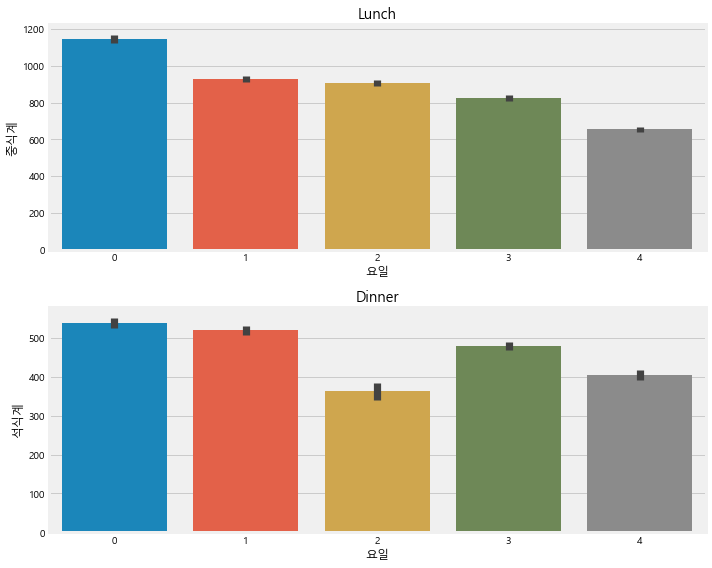

In [104]:
make_barplot('요일')

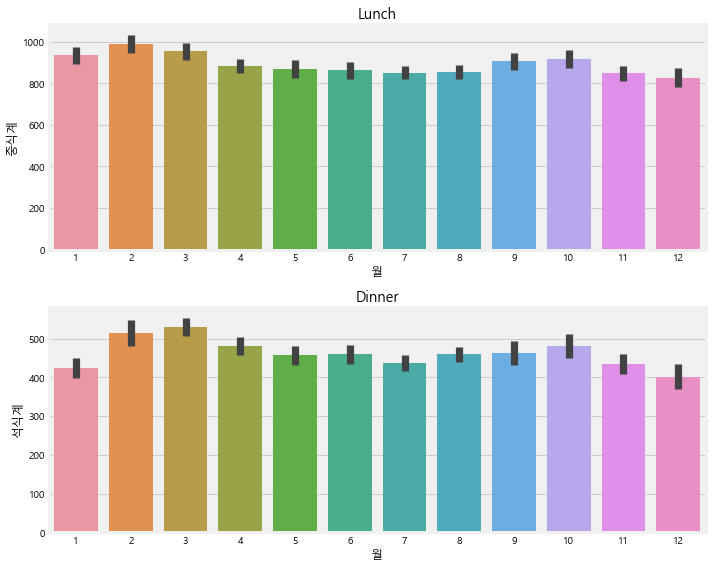

In [105]:
make_barplot('월')

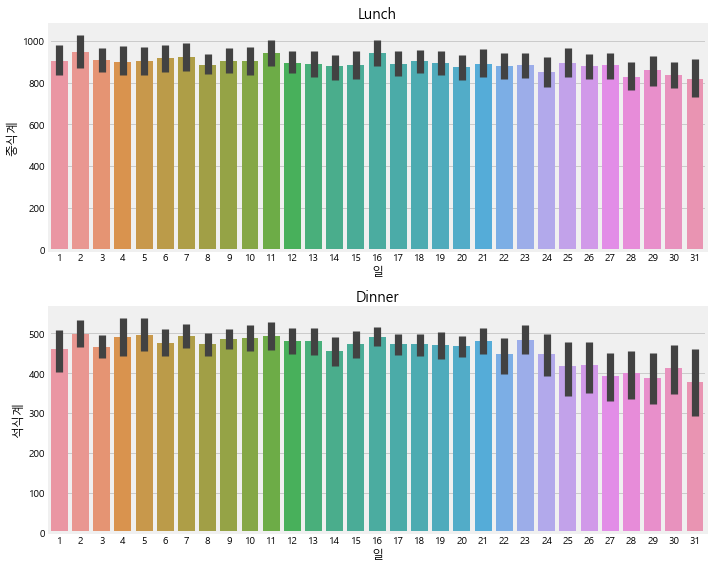

In [106]:
make_barplot('일')

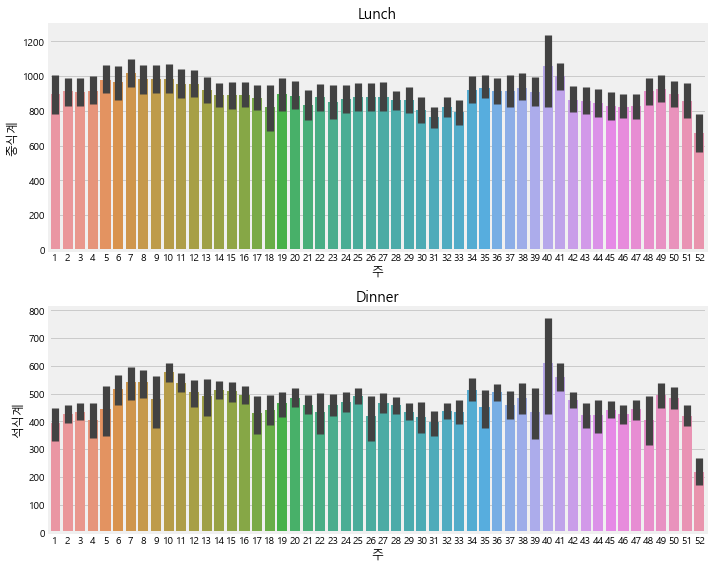

In [107]:
make_barplot('주')

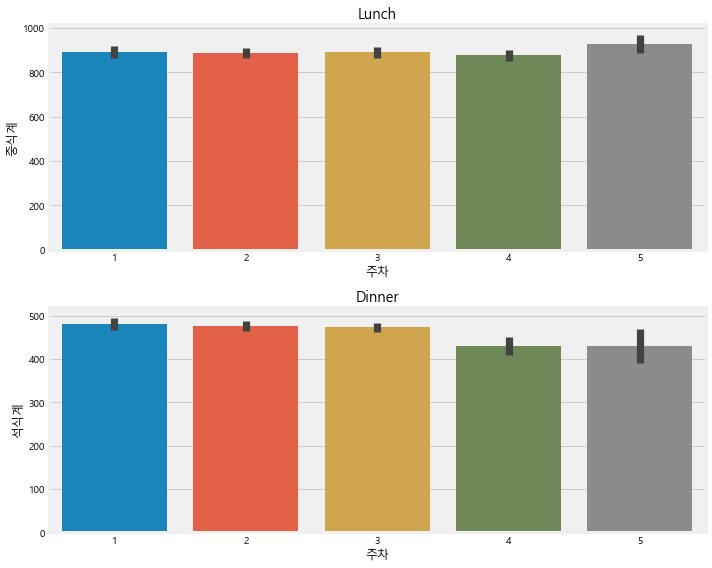

In [108]:
make_barplot('주차')

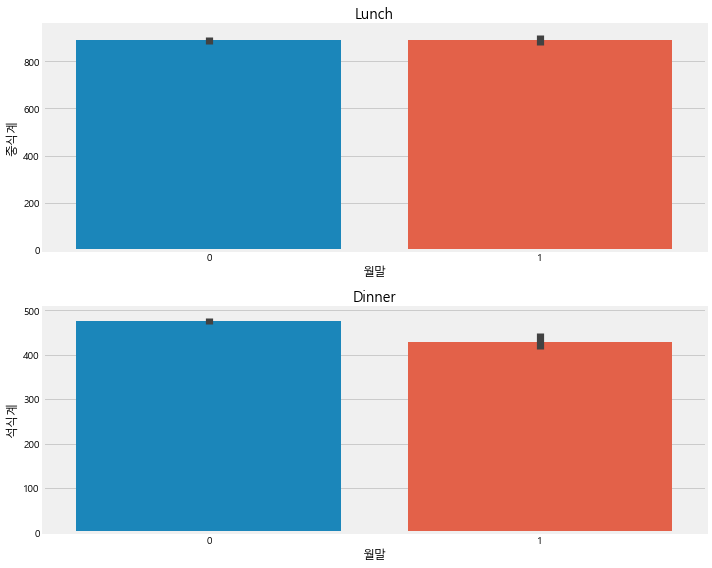

In [109]:
make_barplot('월말')

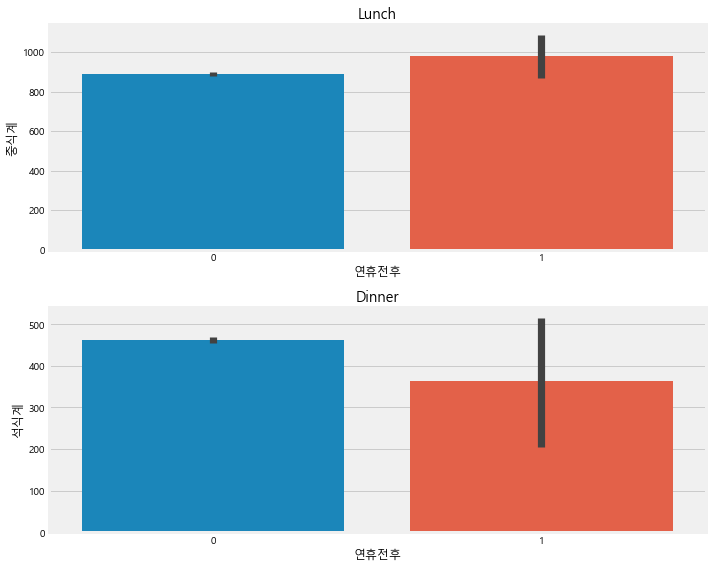

In [110]:
make_barplot('연휴전후')

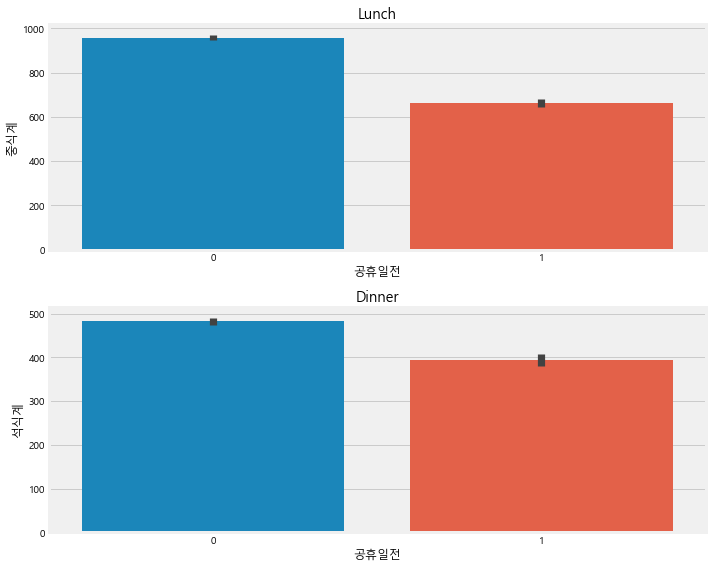

In [111]:
make_barplot('공휴일전')

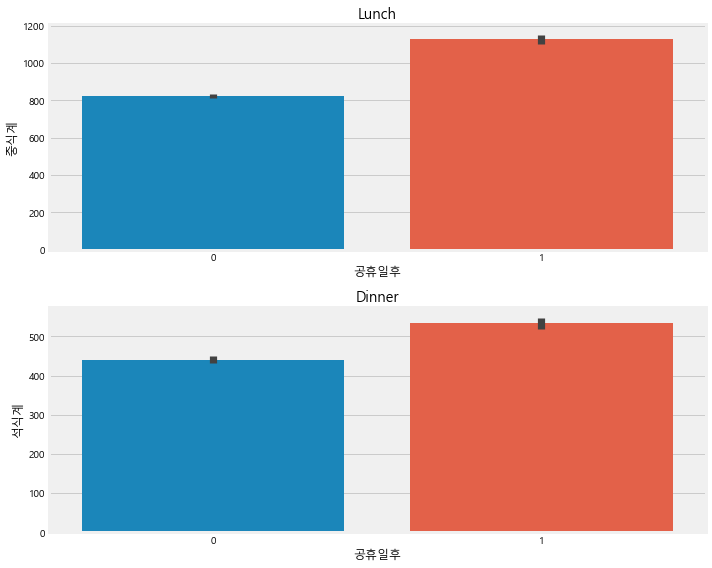

In [112]:
make_barplot('공휴일후')

In [113]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일', '주',
       '출근', '주차', '연휴전후', '공휴일전', '공휴일후', '월말'],
      dtype='object')

In [114]:
## 우선 메뉴 삭제
# data1 = train.drop(['일자', '조식메뉴', '중식메뉴', '석식메뉴'], axis=1)
# data2 = test.drop(['일자', '조식메뉴', '중식메뉴', '석식메뉴'], axis=1)
data1 = train.drop(['일자', '조식메뉴', '년', '주차'], axis=1)
data2 = test.drop(['일자', '조식메뉴', '년', '주차'], axis=1)
submission = pd.DataFrame(test['일자'])

In [115]:
from gensim.models import Word2Vec
# from gensim.models import FastText
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# HYPER PARAMETERS

class CFG:
    emb_dim = 200

args = CFG

In [116]:
# Basic text preprocessing

def split_process(x, q):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [117]:
df = pd.concat([data1, data2])

# Get all combinations for training w2v (train + test)

food_combinations = []
for i in ['중식메뉴', '석식메뉴']:
    food_combinations += df[i].apply(lambda x: split_process(x, i)).to_list()

In [118]:
# Train or load w2v model

TRAIN_W2V = True
try:
    model = Word2Vec.load('food_embedding.model')
    print("Model loaded")
except:
    if TRAIN_W2V:
        print("Training w2v")
        model = Word2Vec(sentences=food_combinations, vector_size=args.emb_dim, window=7, min_count=0, workers=4, sg=0, epochs=5000)
        model.save('food_embedding.model')
    else:
        print("Model loading failed. Do not train.")

Model loaded


In [119]:
# # Train or load w2v model

# TRAIN_W2V = True
# try:
#     model = FastText.load('food_embedding_fastext.model')
#     print("Model loaded")
# except:
#     if TRAIN_W2V:
#         print("Training w2v")
#         model = FastText(sentences=food_combinations, vector_size=args.emb_dim, window=7, min_count=0, workers=4, sg=0, epochs=5000)
#         model.save('food_embedding_fastext.model')
#     else:
#         print("Model loading failed. Do not train.")

In [120]:
# w2v demo
model.wv.most_similar('된장찌개')

[('차돌박이찌개', 0.5288131237030029),
 ('쇠고기미역국', 0.5220195055007935),
 ('근대국', 0.5112987756729126),
 ('순두부찌개', 0.5081377029418945),
 ('아욱국', 0.4967772662639618),
 ('어묵국', 0.4867500364780426),
 ('버섯들깨탕', 0.44841158390045166),
 ('매운소고기국', 0.44336625933647156),
 ('콩비지찌개', 0.4406695067882538),
 ('고추장찌개', 0.43975552916526794)]

In [121]:
# # fastext demo
# model.wv.most_similar('된장찌개')

In [122]:
model.wv.most_similar('마늘쫑무침')

[('사과맛살초무침', 0.43494918942451477),
 ('물파래무침', 0.4202533960342407),
 ('참나물생채', 0.40832072496414185),
 ('치커리사과생채', 0.40463951230049133),
 ('취나물', 0.39294174313545227),
 ('매운어묵무침', 0.39241307973861694),
 ('양념깻잎지', 0.38955047726631165),
 ('세발나물생채', 0.3859693706035614),
 ('꽈리고추찜', 0.3836379945278168),
 ('상추겉절이', 0.3832229971885681)]

In [123]:
# model.wv.most_similar('마늘쫑무침')

In [124]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    vec_ = np.zeros(args.emb_dim)
    for i in x_:
        vec = model.wv.get_vector(i)
        vec_ += vec
    vec_ /= len(x_)
    return vec_

In [125]:
data1['중식메뉴_embedding'] = data1['중식메뉴'].apply(lambda x: get_food_embedding(x))
data1['석식메뉴_embedding'] = data1['석식메뉴'].apply(lambda x: get_food_embedding(x))

data2['중식메뉴_embedding'] = data2['중식메뉴'].apply(lambda x: get_food_embedding(x))
data2['석식메뉴_embedding'] = data2['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [126]:
data1 = data1.drop(['중식메뉴','석식메뉴'], axis=1)
data2 = data2.drop(['중식메뉴','석식메뉴'], axis=1)

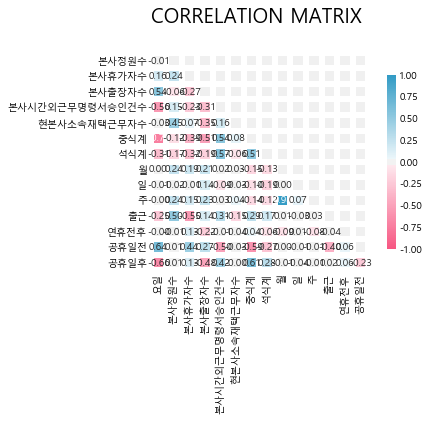

In [127]:
# li2=['요일', '년', '월', '일', '주', '공휴일전후']
# label2_drop = data1[data1.columns.difference(li2)]

# fig, ax = plt.subplots(figsize=(20, 20))
plt.figure()
plt.rcParams['figure.figsize'] = [20, 10] # [width, height]
plt.rcParams['font.family'] = 'Malgun Gothic'
df_corr = data1.corr()

# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

# title
title = 'CORRELATION MATRIX\n'
plt.title(title, loc='left', fontsize=20)
plt.show()

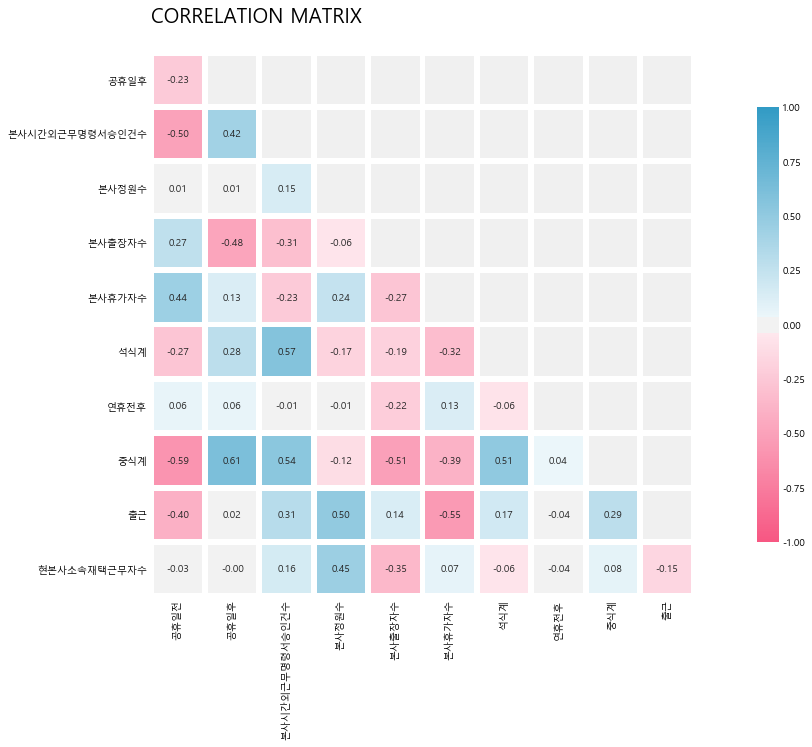

In [128]:
li2=['요일', '년', '월', '일', '주', '주차', '공휴일전후']
label2_drop = data1[data1.columns.difference(li2)]

# fig, ax = plt.subplots(figsize=(20, 20))
plt.figure()
plt.rcParams['figure.figsize'] = [20, 10] # [width, height]
plt.rcParams['font.family'] = 'Malgun Gothic'
df_corr = label2_drop.corr()

# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

# title
title = 'CORRELATION MATRIX\n'
plt.title(title, loc='left', fontsize=20)
plt.show()

In [129]:
x = data1.drop(['중식계', '석식계'], axis=1)
y1 = data1['중식계']  ## 중식계
y2 = data1['석식계']  #석식계

In [130]:
# train
X_common1 = x.iloc[:, :14]

# test
X_common2 = data2.iloc[:, :14]

In [131]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

#alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df=pd.DataFrame()
    if verbose:
        print('######',model_name,'######')
    for param in params:
        if model_name=='Ridge':
            model=Ridge(alpha=param)
        elif model_name=='Lasso':
            model=Lasso(alpha=param)
        neg_mse_scores=cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)
        avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5-fold 세트의 평균 RMSE:{1:.3f}'.format(param, avg_rmse))
        
        model.fit(X_data_n, y_target_n)
        
        if return_coeff:
            coeff=pd.Series(data=model.coef_, index=X_data_n.columns)
            colname='alpha:'+str(param)
            coeff_df[colname]=coeff
    return coeff_df

In [132]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_common1, y_target_n=y1)

###### Lasso ######
alpha 0.07일 때 5-fold 세트의 평균 RMSE:1182.546
alpha 0.1일 때 5-fold 세트의 평균 RMSE:1173.384
alpha 0.5일 때 5-fold 세트의 평균 RMSE:1043.496
alpha 1일 때 5-fold 세트의 평균 RMSE:875.123
alpha 3일 때 5-fold 세트의 평균 RMSE:204.078


In [133]:
sort_column='alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
공휴일후,177.166539,176.778797,171.629845,165.193655,139.461242
주,4.884578,4.863307,4.554901,4.169393,2.627018
연휴전후,1.090783,0.000000,0.000000,0.000000,0.000000
출근,0.111840,0.111369,0.104250,0.095351,0.067509
현본사소속재택근무자수,0.073851,0.072882,0.061722,0.047773,0.000000
본사시간외근무명령서승인건수,0.033988,0.034264,0.037812,0.042247,0.059987
월말,-0.000000,-0.000000,0.000000,0.000000,0.000000
본사정원수,-0.155719,-0.155158,-0.147346,-0.137581,-0.106275
본사휴가자수,-0.527587,-0.528565,-0.541992,-0.558775,-0.618204
일,-1.482361,-1.477340,-1.418803,-1.345633,-1.053024


점심  

월말이랑 연휴 전후 변수가 걍 쓰레기..............  
현본사소속재택근무자수, 본사시간외근무명령서승인건수도 크게 의미 없어보임

In [134]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_common1, y_target_n=y2)

###### Lasso ######
alpha 0.07일 때 5-fold 세트의 평균 RMSE:1016.894
alpha 0.1일 때 5-fold 세트의 평균 RMSE:1006.305
alpha 0.5일 때 5-fold 세트의 평균 RMSE:865.220
alpha 1일 때 5-fold 세트의 평균 RMSE:689.167
alpha 3일 때 5-fold 세트의 평균 RMSE:110.315


In [135]:
sort_column='alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
공휴일전,44.143192,43.827497,39.618232,34.340736,17.914697
공휴일후,31.720106,31.390661,26.998064,21.506416,0.000000
요일,12.174060,12.070490,10.689556,8.959035,5.443889
주,2.639309,2.606944,2.175406,1.635982,0.000000
본사시간외근무명령서승인건수,0.322575,0.322540,0.322077,0.321491,0.320954
출근,-0.034930,-0.033390,-0.012862,0.004230,0.043934
본사정원수,-0.084017,-0.085795,-0.109501,-0.130646,-0.177014
현본사소속재택근무자수,-0.210266,-0.207840,-0.175494,-0.143530,-0.093631
본사휴가자수,-0.290472,-0.288293,-0.259237,-0.231387,-0.156213
본사출장자수,-0.718839,-0.712212,-0.623849,-0.521672,-0.406896


저녁  

출근, 본사정원수도 크게 의미 없어보임

In [136]:
lun_drop = ['월말', '연휴전후', '현본사소속재택근무자수', '본사시간외근무명령서승인건수']
din_drop = ['출근', '본사정원수']

X_common1 = X_common1.drop(lun_drop, axis=1)
X_common12 = X_common1.drop(din_drop, axis=1)

X_common2 = X_common2.drop(lun_drop, axis=1)
X_common23 = X_common2.drop(din_drop, axis=1)

In [137]:
# train
emb_arr_lunch1 = np.array(x.iloc[:, 14].to_numpy().tolist()) # Ver 2
emb_arr_dinner1 = np.array(x.iloc[:, 15].to_numpy().tolist()) # Ver 2

X_train_lunch = np.concatenate((X_common1.to_numpy(), emb_arr_lunch1), axis=1)
X_train_dinner = np.concatenate((X_common12.to_numpy(), emb_arr_dinner1), axis=1)

In [138]:
# test
emb_arr_lunch2 = np.array(data2.iloc[:, 14].to_numpy().tolist()) # Ver 2
emb_arr_dinner2 = np.array(data2.iloc[:, 15].to_numpy().tolist()) # Ver 2

X_test_lunch = np.concatenate((X_common2.to_numpy(), emb_arr_lunch2), axis=1)
X_test_dinner = np.concatenate((X_common23.to_numpy(), emb_arr_dinner2), axis=1)

In [139]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_train_lunch, y1, test_size=0.3, random_state=777)  #점심
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_dinner, y2, test_size=0.3, random_state=777)  #저녁

In [140]:
print("lunch : ", X_train1.shape, X_test1.shape, Y_train1.shape, Y_test1.shape)
print("dinner : ", X_train2.shape, X_test2.shape, Y_train2.shape, Y_test2.shape)

lunch :  (843, 210) (362, 210) (843,) (362,)
dinner :  (843, 208) (362, 208) (843,) (362,)


#### XGBoost 
{'boosting_type': 'gbtree', 'learning_rate': 0.1}  
{'boosting_type': 'gbtree', 'learning_rate': 0.08}

In [141]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

params = {
    'learning_rate': [0.02, 0.05, 0.1, 0.06, 0.08],
    'boosting_type': ['gbtree', 'gblinear', 'dart']
#     'min_child_weight': [1, 5, 10],
#     'gamma': [0.5, 1, 1.5, 2, 5],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'max_depth': [3, 4, 5]
}

# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

lunch_r = XGBRegressor(objective='reg:squarederror')
dinner_r = XGBRegressor(objective='reg:squarederror')

lunch_model = GridSearchCV(lunch_r, params, scoring='neg_mean_absolute_error')
dinner_model = GridSearchCV(dinner_r, params, scoring='neg_mean_absolute_error')

In [142]:
lunch_model.fit(X_train1, Y_train1)
print(lunch_model.best_score_, lunch_model.best_params_)

lunch_model = lunch_model.best_estimator_
y_pred1 = lunch_model.predict(X_test1)
print(lunch_model.score(X_test1, Y_test1))


dinner_model.fit(X_train2, Y_train2)
print(dinner_model.best_score_, dinner_model.best_params_)

dinner_model = dinner_model.best_estimator_
y_pred2 = dinner_model.predict(X_test2)
print(dinner_model.score(X_test2, Y_test2))

-71.78878462429482 {'boosting_type': 'gbtree', 'learning_rate': 0.08}
0.7948181594198626
-65.92297563751706 {'boosting_type': 'gbtree', 'learning_rate': 0.1}
0.6879583545278875


In [143]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(Y_test1, y_pred1))
print(mean_absolute_error(Y_test2, y_pred2))

73.9710056873975
58.27128181569484


In [144]:
y_pred_test1 = pd.DataFrame(lunch_model.predict(X_test_lunch))
y_pred_test2 = pd.DataFrame(dinner_model.predict(X_test_dinner))

In [145]:
y_pred_test1.columns = ['중식계']
y_pred_test2.columns = ['석식계']

submission = pd.concat([submission, y_pred_test1, y_pred_test2], axis=1)
submission

,일자,중식계,석식계
0,2021-01-27,982.957886,383.963837
1,2021-01-28,961.302429,436.039368
2,2021-01-29,778.005676,345.095093
3,2021-02-01,1238.161011,505.673553
4,2021-02-02,1042.596558,507.665161
5,2021-02-03,989.688965,418.177307
6,2021-02-04,956.519531,406.645935
7,2021-02-05,859.157043,482.181885
8,2021-02-08,1209.276367,601.792480
9,2021-02-09,1014.344055,575.481384


In [146]:
submission.to_csv('submission.csv', index=False)